## Overview

## 1. Load packages/modules

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopy.geocoders

from cartopy.feature import ShapelyFeature
from shapely.geometry import Point
from functools import partial
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import GoogleV3

%matplotlib notebook

# constant
douro_path = "./data_source/douro/"  # path to load Douro datasets
alentejio = "./data_source/alentejo/" # path to load Alentejio datasets 

## 2. Methods section

In [2]:
def addressGeocoded(df,gc):
    '''
    This function accepts a dataframe and a geocode object and returns a geo dataframe
    
    :param df: dataframe with addresses
    :param gc: geocode object
    
    :returns geodataframe
    '''
    tmp_df = df.copy() # create a copy of the original dataframe, in this way no changes will be applied to the original one
    tmp_df['geolocation'] = tmp_df['address'].apply(gc) # translate address into coordinate
    tmp_df['geometry'] = tmp_df['geolocation'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None) #extract tuple point location
    tmp_df['geometry'] = tmp_df['geometry'].apply(Point) # convert tuple in shapely geometry point
    gdf = gpd.GeoDataFrame(tmp_df)
    gdf.set_crs("EPSG:3763", inplace=True) #Set the projection to the ETRS89/PT-TMS09
    gdf = gdf.drop(columns=['geolocation']) #Drop geolocation information; shapefile only accept one geometry column when saving the geodataframe
    gdf.to_file("./data_source/douro/douro_wine_producers.shp") # save the geodataframe in shape file; in this way no queries are sent to Google geocoding service
    return gdf

## 3. Load the data

Portugal municipalities and parishes are loaded from the shapefile *Cont_AAD_CAOP2020*; source [**DgTerritorio**](https://www.dgterritorio.gov.pt/cartografia/cartografia-tematica/caop?language=en) and load Douro municipalities and parishes dataset reporting the informtion where the douro wine is produced; source [**IVV**](https://www.ivv.gov.pt/np4/%7B$clientServletPath%7D/?newsId=1736&fileName=IVV_WEB_TB.PDF)

In [3]:
### Laod Portugal municipalities.
pt_municipalities_gdf = gpd.read_file("./data_source/Cont_AAD_CAOP2020/Cont_AAD_CAOP2020.shp")
#pt_municipalities_gdf.shape
#pt_municimunicipalities_gdf.head(15)

In [4]:
### Load Douro municipalities and parishes dataset where douro wine is produced.
douro_municipalities_df = pd.read_excel(douro_path+"douro_municipality_parish.xlsx")
douro_municipalities_df.shape
douro_municipalities_df.head()

,Area Geografica,Concelhos,Frequesias
0,Baxio Corgo,Mesão Frio,NaN
1,Baxio Corgo,Peso da Régua,NaN
2,Baxio Corgo,Santa Marta de Penaguião,NaN
3,Baxio Corgo,Vila Real,Abaças
4,Baxio Corgo,Vila Real,Ermida


In [5]:
# Get the list of unique Douro municipalities
unique_munic = douro_municipalities_df['Concelhos'].unique()
pt_douro_munic_gdf = pt_municipalities_gdf[pt_municipalities_gdf['Concelho'].apply(lambda muni: muni in unique_munic)] #extract Douro municipalities from Portugal dataset

In [6]:
pt_douro_munic_gdf.head() #Check the dataframe

,Dicofre,Freguesia,Concelho,Distrito,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,geometry
214,090410,Mata de Lobos,Figueira de Castelo Rodrigo,Guarda,ÁREA PRINCIPAL,3697.29,3697.29,Mata de Lobos,"POLYGON ((108183.030 137946.011, 107387.875 13..."
229,090918,Prova e Casteição,Mêda,Guarda,ÁREA PRINCIPAL,2602.61,2602.61,Prova e Casteição,"POLYGON ((69087.504 144866.380, 69070.975 1448..."
660,090406,Escalhão,Figueira de Castelo Rodrigo,Guarda,ÁREA PRINCIPAL,7880.74,7880.74,Escalhão,"POLYGON ((100800.954 151822.754, 100845.704 15..."
661,180511,Lazarim,Lamego,Viseu,ÁREA PRINCIPAL,1653.84,1653.84,Lazarim,"POLYGON ((25364.680 151852.479, 25377.150 1518..."
663,091401,Almendra,Vila Nova de Foz Côa,Guarda,ÁREA PRINCIPAL,5440.65,5440.65,Almendra,"POLYGON ((95730.137 152175.506, 95762.159 1520..."


In [7]:
# Check all the douro wine production municipalities are in the new sub geodataframe 
print(pt_douro_munic_gdf['Concelho'].unique().shape)
print(unique_munic.shape)
test_list = []
for element in unique_munic:
    if element not in pt_douro_munic_gdf['Concelho'].unique():
        test_list.append(element)
print(test_list)
pt_municipalities_gdf[pt_municipalities_gdf['Freguesia']=='Escalhão']

(20,)
(20,)
[]


,Dicofre,Freguesia,Concelho,Distrito,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,geometry
660,090406,Escalhão,Figueira de Castelo Rodrigo,Guarda,ÁREA PRINCIPAL,7880.74,7880.74,Escalhão,"POLYGON ((100800.954 151822.754, 100845.704 15..."


In [8]:
### Load Douro wine producers dataset
douro_wine_producers_df = pd.read_excel(douro_path+"douro_wine_producers_list.xlsx")
douro_wine_producers_df.head(15)

,producer,address
0,Quinta do Judeu,"Estrada EM313, Peso da Regua 5050, Vila Real"
1,Adega Cooperativa de Mesao Frio,"Avenida Dr. Domingos Monteiro Fundo de Vila, 5..."
2,Adega Cooperativa de Sabrosa,"Rua das Flores 27, Alto de Paços, 5060-321 Sab..."
3,Adega Vila Real,"Vale Frio - Folhadela, Vila Real 5000"
4,Aneto,"Quinta do Paco, 5050-090 Godim, Vila Real"
5,Bago de Touriga,"Urb Vila Paulista, 5000-262 Vila Real, Douro"
6,Bom Viver,"Quinta do Espinho, 5030-456 Santa Marta de Pen..."
7,Calheiros Cruz,"Quinta de Covelos, Canelas, 5050 - 426 Peso da..."
8,Caves Transmontanas,"Rua de Sao Domingos 22, 5070 Alijo, Vila Real"
9,Caves Vale do Rodo,"Rua da Lousada, Peso da Regua 5050, Vila Real"


In [ ]:
### Instance Google connection for geocoding - This is done only once; when the douro_wine_producers_df is loaded for the first time
geopy.geocoders.options.default_user_agent = 'wine_app'
geopy.geocoders.options.default_scheme = 'https'
with open("./data_source/apikey.txt") as f:   #load Google API key
    apikey = f.readline()
    f.close
geolocator = GoogleV3(api_key=apikey)
geocode = partial(geolocator.geocode, language="en")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)
# Query Google
douro_wine_producers_gdf = addressGeocoded(douro_wine_producers_df,geocode)

In [9]:
douro_wine_producers_gdf = gpd.read_file("./data_source/douro/douro_wine_producers.shp")
douro_wine_producers_gdf.head(10)

,producer,address,geometry
0,Quinta do Judeu,"Estrada EM313, Peso da Regua 5050, Vila Real",POINT (41.17185 -7.73081)
1,Adega Cooperativa de Mesao Frio,"Avenida Dr. Domingos Monteiro Fundo de Vila, 5...",POINT (41.15705 -7.89394)
2,Adega Cooperativa de Sabrosa,"Rua das Flores 27, Alto de Paços, 5060-321 Sab...",POINT (41.26240 -7.58068)
3,Adega Vila Real,"Vale Frio - Folhadela, Vila Real 5000",POINT (41.27370 -7.71892)
4,Aneto,"Quinta do Paco, 5050-090 Godim, Vila Real",POINT (41.29160 -7.70775)
5,Bago de Touriga,"Urb Vila Paulista, 5000-262 Vila Real, Douro",POINT (41.31117 -7.72154)
6,Bom Viver,"Quinta do Espinho, 5030-456 Santa Marta de Pen...",POINT (41.20179 -7.78580)
7,Calheiros Cruz,"Quinta de Covelos, Canelas, 5050 - 426 Peso da...",POINT (41.16201 -7.76678)
8,Caves Transmontanas,"Rua de Sao Domingos 22, 5070 Alijo, Vila Real",POINT (41.27245 -7.49902)
9,Caves Vale do Rodo,"Rua da Lousada, Peso da Regua 5050, Vila Real",POINT (41.17405 -7.79597)


In [10]:
### Load Douro Region shapefile
douro_gdf = gpd.read_file(douro_path+"RDD_ETRS89/RDD_ETRS89.shp")

## 4. Create the map of Douro
Cartopy and Matplotlib are used; first fig object is created to contain Axes object

<IPython.core.display.Javascript object>


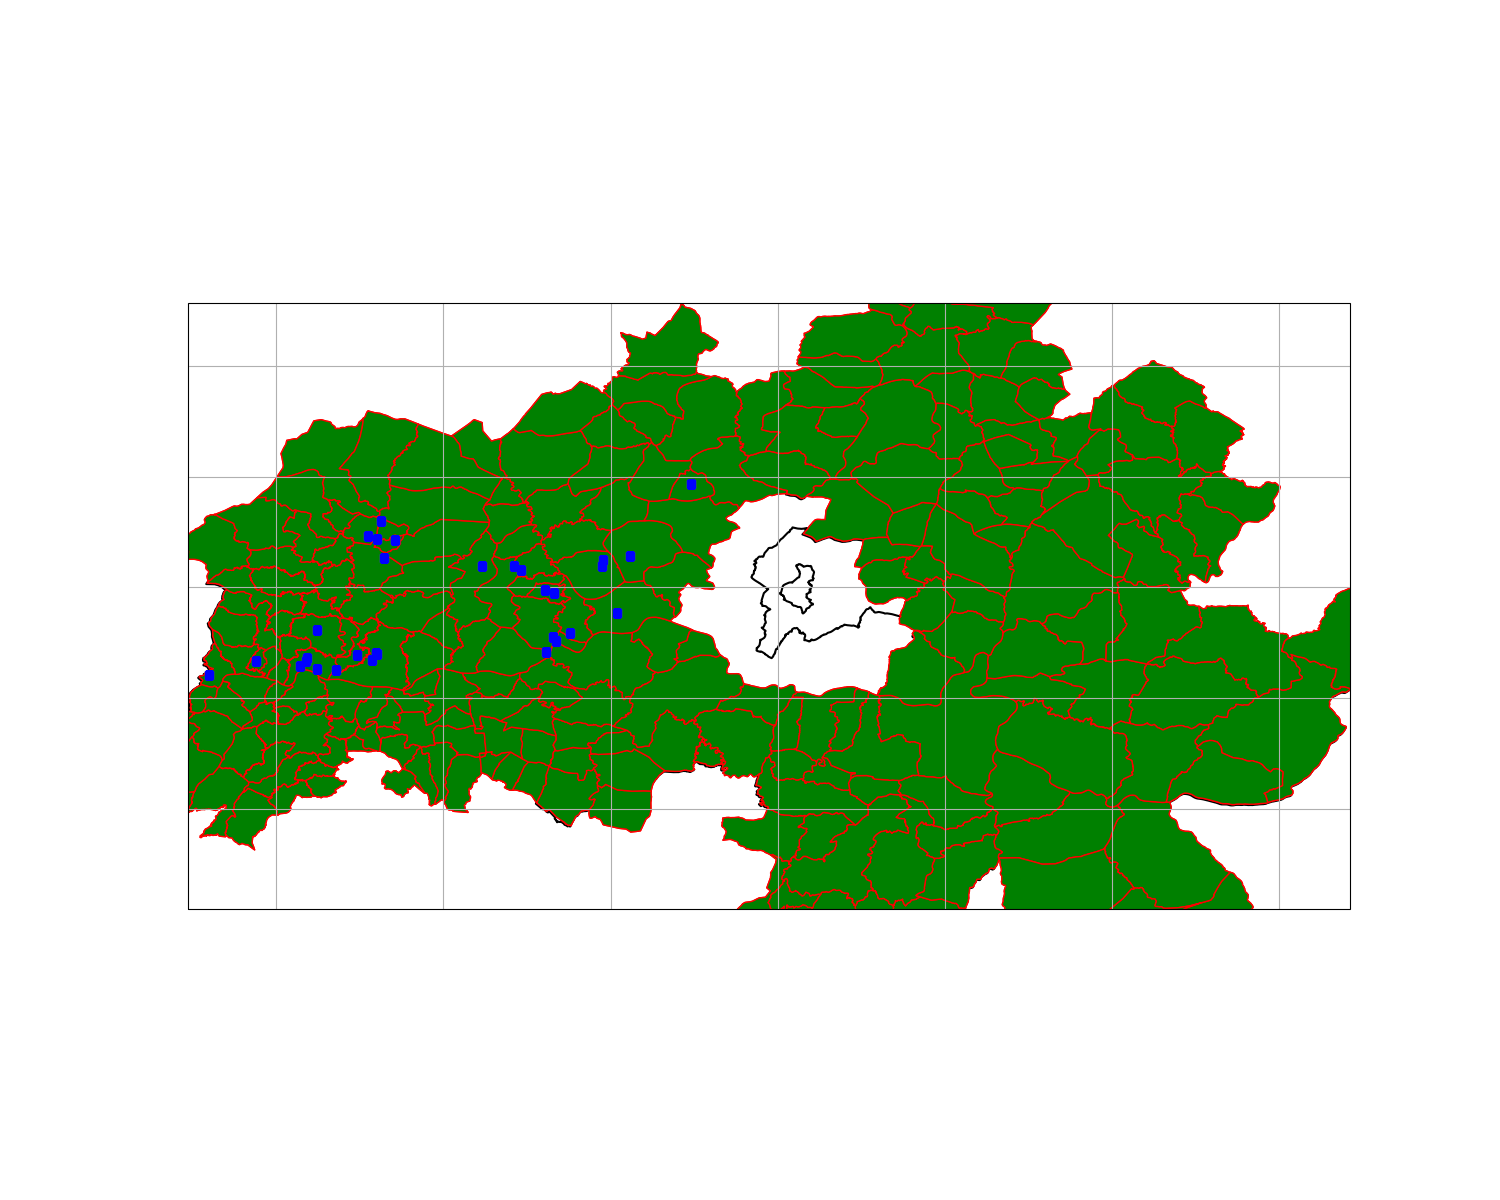

<IPython.core.display.Javascript object>


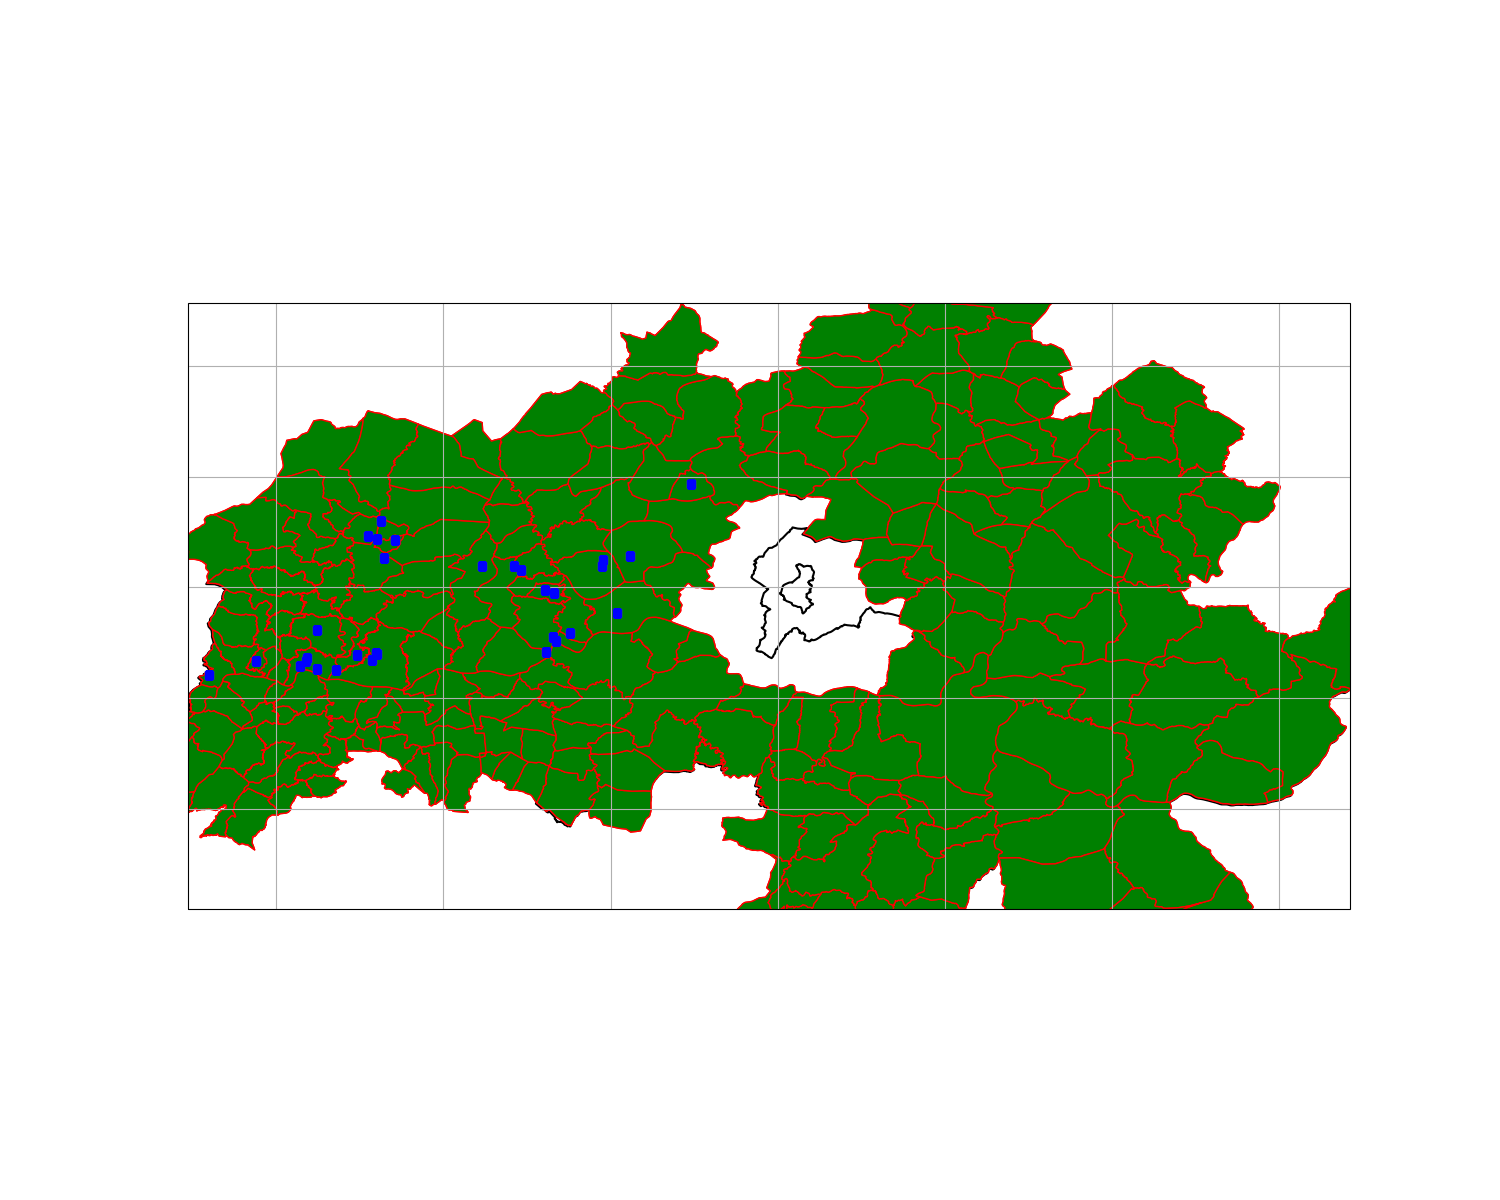

In [32]:
# Create the figure layout
pt_crs = ccrs.UTM(29) #Universal Trasverse Marcator system for Portugal
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection=ccrs.Mercator()) # create axes object with Maractor projection
ax.gridlines()
douro_region = ShapelyFeature(douro_gdf['geometry'], pt_crs, edgecolor='k',linewidth=1.5,facecolor='w')
ax.add_feature(douro_region)# add the douro region borders
# using the boundary of the shapefile features, zoom the map to our area of interest
xmin, ymin, xmax, ymax = douro_gdf.total_bounds #total_bounds gives output as xmin, ymin, xmax, ymax,
ax.set_extent([xmin, xmax, ymin, ymax], crs=pt_crs) #set_extent allow to zoom in the area of interest
fig

### Add Features
Before adding such as municipalites and point location, CRS need to be checked for avoding wrong rappresentation

#### Municipalities & parishes

In [13]:
pt_douro_munic_gdf.crs

<Projected CRS: EPSG:3763>
Name: ETRS89 / Portugal TM06
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Portugal - mainland - onshore
- bounds: (-9.56, 36.95, -6.19, 42.16)
Coordinate Operation:
- name: Portugual TM06
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The Portugal municipality shapefile uses EPSG:3763 that it's a prjection and the coordinates are geometric, while the Douro image uses geographic coordinates. The sub set of Portugal municipalities related to Douro needs to be converted before being plotted

<IPython.core.display.Javascript object>


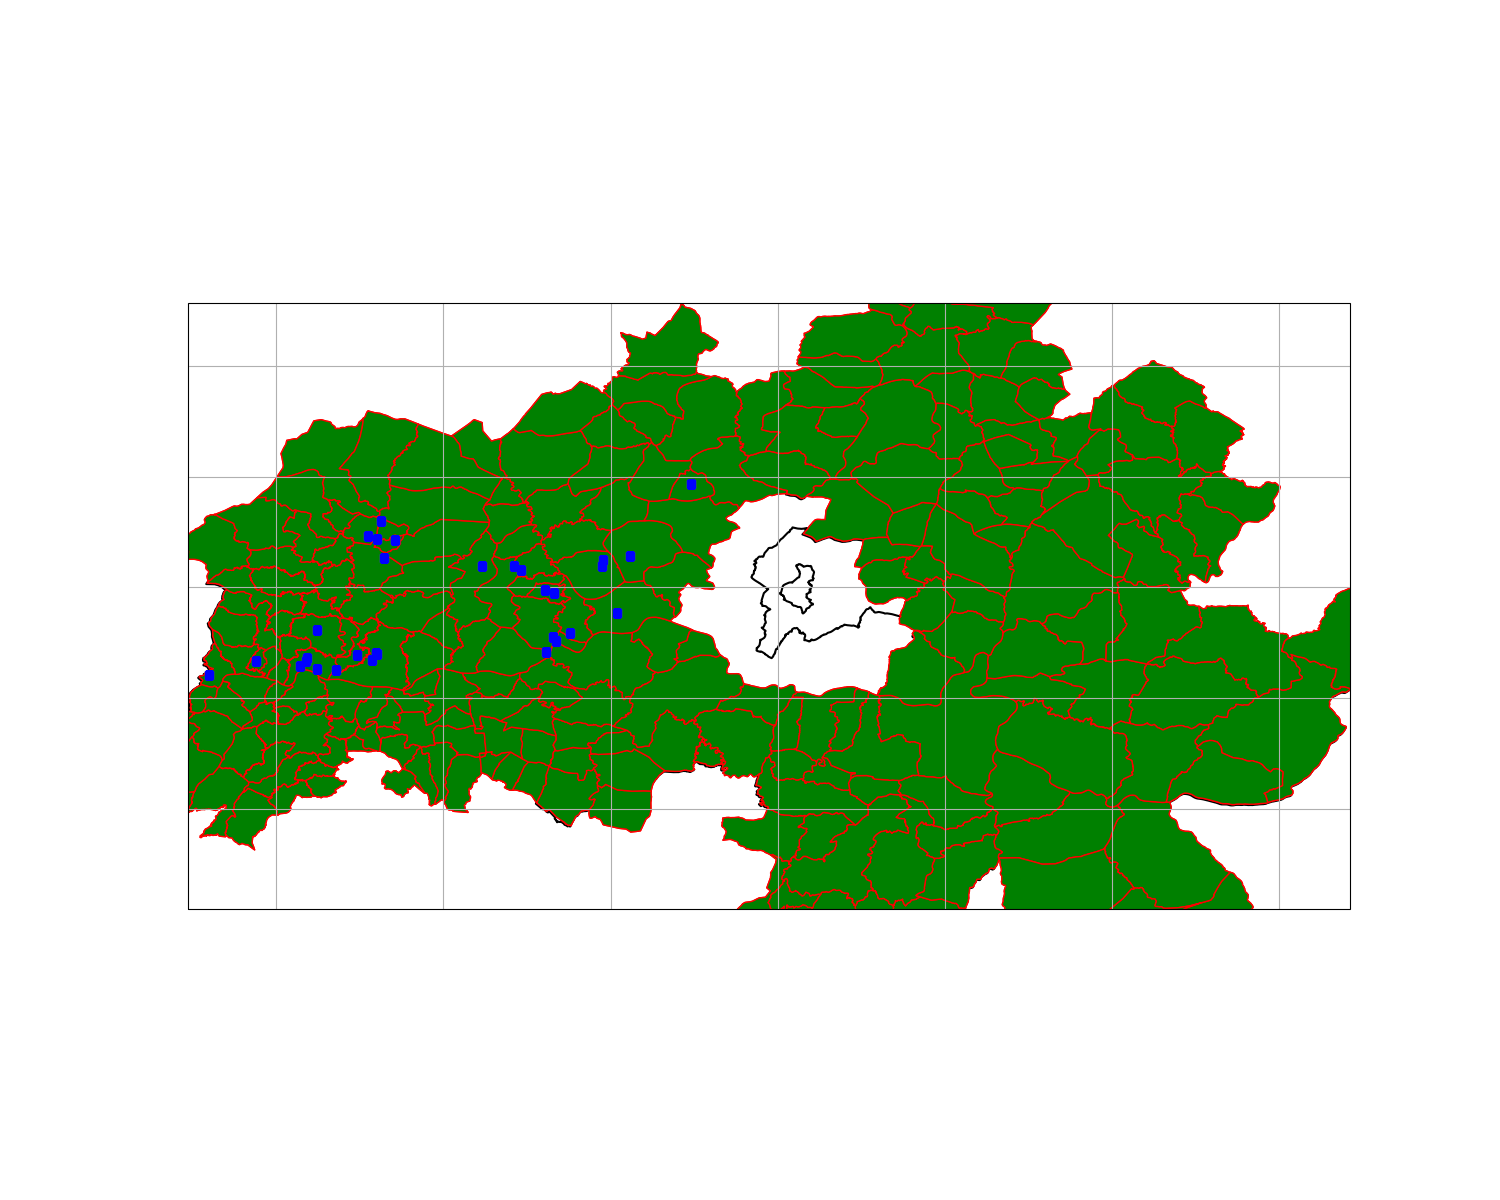

In [34]:
pt_douro_munic_wgs84 = pt_douro_munic_gdf.to_crs("EPSG:4326") # Conversion from Cartesian to Geographic coordinates
douro_municip = ShapelyFeature(pt_douro_munic_wgs84['geometry'], pt_crs, edgecolor='red',linewidth=1,facecolor='green')
ax.add_feature(douro_municip)# add the douro region borders
ax.plot(douro_wine_producers_gdf.geometry.y,douro_wine_producers_gdf.geometry.x,'s', color='blue',transform=pt_crs)
fig